In [1]:
%pylab inline
rcParams.update({"font.size":15})

Populating the interactive namespace from numpy and matplotlib


### 0. generate random data

Text(0.5, 1.0, 'sin model')

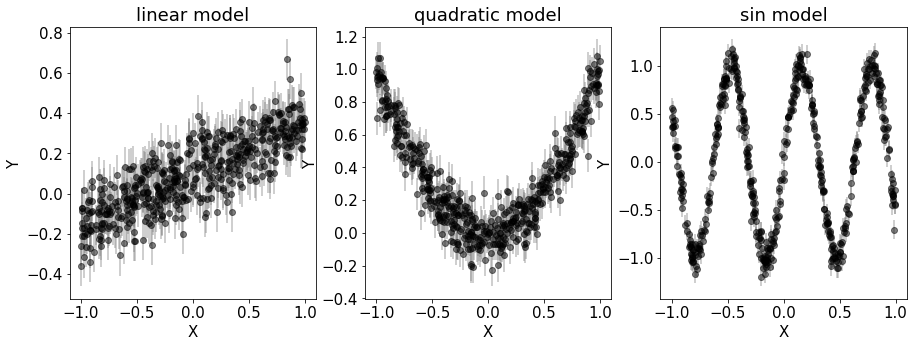

In [2]:
ntest = 500
np.random.seed(123)
# linear model
theta_true = [0.25, 0.1]
f = lambda x: 0.25*x+0.1
# quadratic model
f2 = lambda x: x**2
# sin model
fs = lambda x: np.sin(x*10)

xrand = np.random.uniform(-1, 1, ntest)
yrand = f(xrand) + np.random.normal(0, 0.1, ntest)
yrand2 = f2(xrand) + np.random.normal(0, 0.1, ntest)
yrands = fs(xrand) + np.random.normal(0, 0.1, ntest)
yerr = np.ones(ntest,)*0.1

fig, axs = subplots(1,3, figsize=(15, 5))
axs[0].errorbar(xrand, yrand, yerr=yerr, fmt="o", alpha=0.5,ecolor="gray", color="k")
axs[0].set_xlabel("X")
axs[0].set_ylabel("Y")
axs[0].set_title("linear model")

axs[1].errorbar(xrand, yrand2, yerr=yerr, fmt="o", alpha=0.5,ecolor="gray", color="k")
axs[1].set_xlabel("X")
axs[1].set_ylabel("Y")
axs[1].set_title("quadratic model")

axs[2].errorbar(xrand, yrands, yerr=yerr, fmt="o", alpha=0.5,ecolor="gray", color="k")
axs[2].set_xlabel("X")
axs[2].set_ylabel("Y")
axs[2].set_title("sin model")

### 1. fit a linear model using `scipy.optimize`

In [3]:
def model(theta, x):
    a, b = theta
    return a*x+b

def costfun(theta, x, y, yerr):
    return 0.5 * np.sum(((y - model(theta, x))/yerr)**2)

from scipy.optimize import minimize
opt = minimize(costfun, x0=[0, 0.], method="Nelder-Mead", args=(xrand, yrand, yerr))
print("Theta_opt = ", opt.x)

Theta_opt =  [0.25561096 0.09985966]


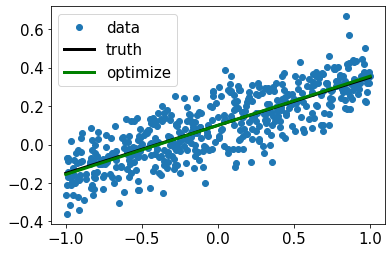

In [4]:
plot(xrand, yrand, 'o', label="data")
xx = np.linspace(-1, 1, 100)
plot(xx, theta_true[0]*xx+theta_true[1], "k-", lw=3, label="truth")
plot(xx, opt.x[0]*xx+opt.x[1], "g-", lw=3, label="optimize")
legend()

### 2. fit a linear model using `emcee`

In [5]:
def model(theta, x):
    a, b = theta
    return a*x+b

def lnlike(theta, x, y, yerr):
    return -0.5 * np.sum(((y - model(theta, x))/yerr)**2)

from emcee import EnsembleSampler
nwalkers=10
ndim=2

# initiate a sampler
s = EnsembleSampler(nwalkers=10, ndim=2, log_prob_fn=lnlike, args=(xrand, yrand, yerr))
# run MCMC
state = s.run_mcmc(initial_state=np.random.normal(0, 1, (nwalkers, ndim)), nsteps=10000, )
# get flatchain and discard burn-in steps
flatchain = s.get_chain(discard=5000).reshape(-1, ndim)

Theta_mcmc =  [0.25552932 0.09975603]


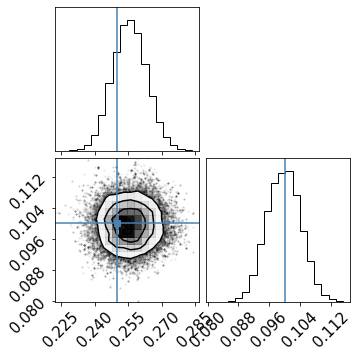

In [6]:
# corner plot
from corner import corner
fig = corner(flatchain, truths=[0.25, 0.1])
theta_med = np.median(flatchain, axis=0)
print("Theta_mcmc = ", theta_med)

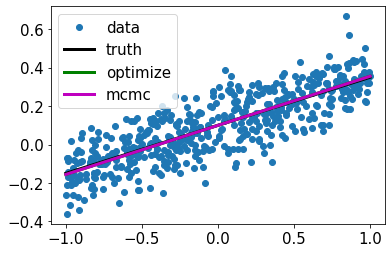

In [7]:
plot(xrand, yrand, 'o', label="data")
xx = np.linspace(-1, 1, 100)
plot(xx, theta_true[0]*xx+theta_true[1], "k-", lw=3, label="truth")
plot(xx, opt.x[0]*xx+opt.x[1], "g-", lw=3, label="optimize")
plot(xx, theta_med[0]*xx+theta_med[1], "m-", lw=3, label="mcmc")
legend()

### 3. machine learning solution - SVR

In [8]:
X = xrand.reshape(-1, 1)
y = yrand

from sklearn.svm import SVR
# initiate SVR model
s = SVR()
# train SVR model
s.fit(X, y)

SVR()

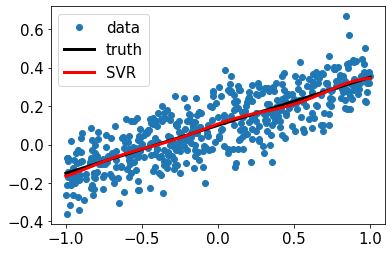

In [9]:
plot(X, y, "o", label="data")
xx = np.linspace(-1, 1, 100).reshape(-1, 1)
plot(xx, theta_true[0]*xx+theta_true[1], "k-", lw=3, label="truth")
plot(xx, s.predict(xx),'r-', lw=3, label="SVR")
legend()

### what if the data is not linear?

In [10]:
X = xrand.reshape(-1, 1)
y = yrand2

from sklearn.svm import SVR
# initiate SVR model
s2 = SVR()
# train SVR model
s2.fit(X, y)

SVR()

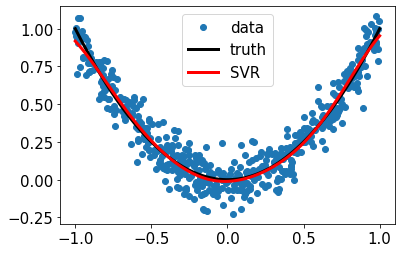

In [11]:
plot(X, y, "o", label="data")
xx = np.linspace(-1, 1, 100).reshape(-1, 1)
plot(xx, f2(xx), "k-", lw=3, label="truth")
plot(xx, s2.predict(xx),'r-', lw=3, label="SVR")
legend()

In [12]:
X = xrand.reshape(-1, 1)
y = yrands

from sklearn.svm import SVR
# initiate SVR model
s2 = SVR(gamma=10)
# train SVR model
s2.fit(X, y)

SVR(gamma=10)

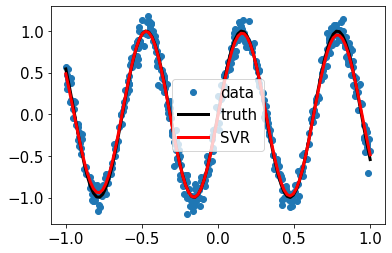

In [13]:
plot(X, y, "o", label="data")
xx = np.linspace(-1, 1, 100).reshape(-1, 1)
plot(xx, fs(xx), "k-", lw=3, label="truth")
plot(xx, s2.predict(xx),'r-', lw=3, label="SVR")
legend()

### 4. machine learning solution - NN

In [14]:
X = xrand.reshape(-1, 1)
y = yrand

from sklearn.neural_network import MLPRegressor
nn = MLPRegressor(hidden_layer_sizes=(10,), activation="tanh",learning_rate="adaptive", learning_rate_init=0.01, solver="sgd")
nn.fit(X, y)

MLPRegressor(activation='tanh', hidden_layer_sizes=(10,),
             learning_rate='adaptive', learning_rate_init=0.01, solver='sgd')

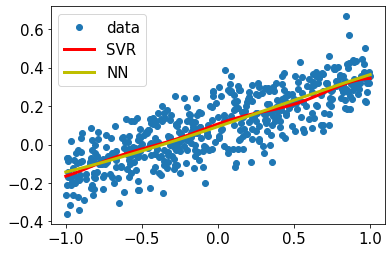

In [15]:
plot(X, y, "o", label="data")
xx = np.linspace(-1, 1, 100).reshape(-1, 1)
plot(xx, s.predict(xx),'r-', lw=3, label="SVR")
plot(xx, nn.predict(xx),'y-', lw=3, label="NN")
legend()

## Homework
1. use `scipy.optimize.minimize` to fit a quadratic model: $f=x^2$
2. use `sklearn.neural_network.MLPRegressor` to fit a quadratic model: $f=x^2$
2. use `tensorflow`/`pytorch`/`keras` to build a multi-layer perceptron regressor (2-->10-->5-->1)